In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        import pandas
import datetime
import numpy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import time
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline

In [12]:
# Some constants
cutOffMLTMLATUniqCnt = 4
cntPntCutoff = 50
# Function for setting MLT
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

In [3]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [28]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
print "DF shape--->", velsDataDF.shape
velsDataDF = velsDataDF.drop_duplicates()
print "DF shape--->", velsDataDF.shape
# Get new cols for 
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
selCols = [ 'date', 'azim', 'MLAT', 'normMLT', 'vSaps']
velsDataDF = velsDataDF[selCols]

DF shape---> (374550, 25)
DF shape---> (254851, 25)
DF shape---> (251675, 5)


In [29]:
# # Also merge with aymDF
# # print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["date"], how='inner')
selCols = [ 'date', 'azim', 'MLAT',\
           'normMLT', 'vSaps', "AsyH"]
velsDataDF = velsDataDF[selCols]
velsDataDF.head()

,date,azim,MLAT,normMLT,vSaps,AsyH
0,2012-10-14 01:00:00,-79.412573,62.0,-6.0,306.738497,33.0
1,2012-10-14 01:00:00,-78.075135,61.5,-6.0,296.893207,33.0
2,2012-10-14 01:00:00,-82.467569,60.0,-6.0,220.239731,33.0
3,2012-10-14 01:00:00,-84.987310,60.5,-6.0,233.815511,33.0
4,2012-10-14 01:00:00,-80.714224,62.0,-5.0,300.901854,33.0


In [30]:
# # Divide asymH index into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
velsDataDF.columns = [ 'date', 'azim', 'MLAT',\
           'normMLT', 'vSaps', "AsyH", "asyh_bin"]
print "DF shape--->", velsDataDF.shape
velsDataDF.head()

DF shape---> (251675, 7)


,date,azim,MLAT,normMLT,vSaps,AsyH,asyh_bin
0,2012-10-14 01:00:00,-79.412573,62.0,-6.0,306.738497,33.0,"(30, 60]"
1,2012-10-14 01:00:00,-78.075135,61.5,-6.0,296.893207,33.0,"(30, 60]"
2,2012-10-14 01:00:00,-82.467569,60.0,-6.0,220.239731,33.0,"(30, 60]"
3,2012-10-14 01:00:00,-84.987310,60.5,-6.0,233.815511,33.0,"(30, 60]"
4,2012-10-14 01:00:00,-80.714224,62.0,-5.0,300.901854,33.0,"(30, 60]"


In [35]:
# groupby spatial and geomag props
cntMLTPntsDF = velsDataDF[ ["asyh_bin", "normMLT", "MLAT", "vSaps"] \
                    ].groupby( ["asyh_bin", "normMLT", "MLAT"] \
                    )["vSaps"].size().reset_index()
cntMLTPntsDF.columns = [ "asyh_bin", "normMLT", "MLAT", "num_pnts" ]
# groupby asy bin to limit our analysis to significant points
cntAsyPntsDF = velsDataDF[ ["asyh_bin", "vSaps"] \
                    ].groupby( ["asyh_bin"] \
                    )["vSaps"].size().reset_index()
cntAsyPntsDF.columns = [ "asyh_bin", "tot_bin_pnts" ]
# Merge the two to get a prob of points
cntMLTPntsDF = pandas.merge( cntMLTPntsDF, cntAsyPntsDF, on=["asyh_bin"] )
cntMLTPntsDF["npnts_perc"] = cntMLTPntsDF["num_pnts"]*100./cntMLTPntsDF["tot_bin_pnts"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["num_pnts"] >= cntPntCutoff-5 ]
cntMLTPntsDF.head()

,asyh_bin,normMLT,MLAT,num_pnts,tot_bin_pnts,npnts_perc
11,"(0, 30]",-6.0,59.0,57,93634,0.060875
12,"(0, 30]",-6.0,59.5,71,93634,0.075827
13,"(0, 30]",-6.0,60.0,89,93634,0.095051
14,"(0, 30]",-6.0,60.5,99,93634,0.105731
15,"(0, 30]",-6.0,61.0,110,93634,0.117479


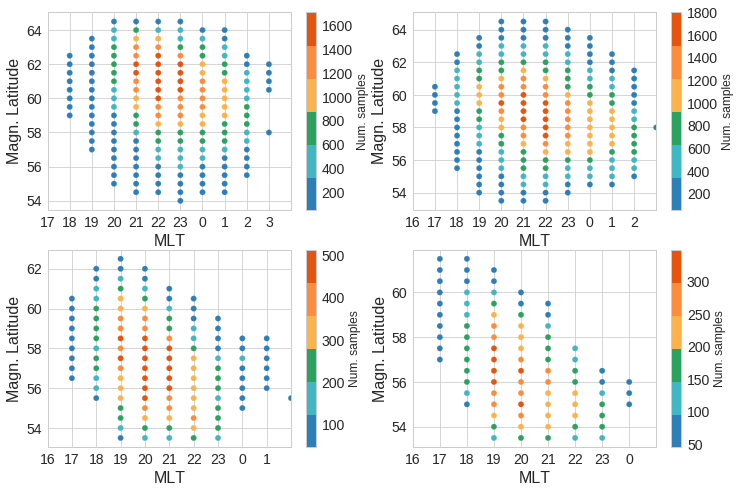

In [47]:
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )


xlim = [-9,2]

def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

sns.set_style("whitegrid")
sns.set_context("paper")

colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]

seaMap = ListedColormap(sns.color_palette(colors))

for nc, asb in enumerate(cntMLTPntsDF['asyh_bin'].unique()):
    currDF = cntMLTPntsDF[ cntMLTPntsDF['asyh_bin'] == asb ]
#     print nc, currDF.shape, asb
#     currDF.plot( kind='scatter',
#               x='normMLT',
#               y='MLAT',
#               c='vSaps',
#               s=currDF["vSaps"]/10,\
#               cmap=seaMap, ax=axArr[nc], label=str(asb))
    sctPlot = axArr[nc].scatter( x=currDF["normMLT"].values,\
                                y=currDF["MLAT"].values,\
                                c=currDF["num_pnts"].values,\
                                s=30.,\
                                cmap=seaMap, label=str(asb) )    
    cbar = plt.colorbar(sctPlot,orientation='vertical',ax=axArr[nc])
    # set axis props
    axArr[nc].xaxis.set_major_formatter(\
                FuncFormatter(format_mlt_normMLT_ticks))
    axArr[nc].set_xlabel("MLT", fontsize=16)
    axArr[nc].set_ylabel("Magn. Latitude", fontsize=16)
    axArr[nc].xaxis.set_tick_params(labelsize=14)
    axArr[nc].yaxis.set_tick_params(labelsize=14)
    if nc == 0:
        axArr[nc].set_xlim( [-7, 4] )
        axArr[nc].set_xticks( range(-7,4) )
    if nc == 1:
        axArr[nc].set_xlim( [-8, 3] )
        axArr[nc].set_xticks( range(-8,3) )
    if nc == 2:
        axArr[nc].set_xlim( [-8, 2] )
        axArr[nc].set_xticks( range(-8,2) )
    if nc == 3:
        axArr[nc].set_xlim( [-8, 1] )
        axArr[nc].set_xticks( range(-8,1) )
#     axArr[nc].legend()
    # set colorbar props
    cbar.set_label('Num. samples', size=12)
    cbar.ax.tick_params(labelsize=14)
plt.savefig("../figs/nPnts-bins.eps",bbox_inches='tight')